# LMM/GLMM analyses for UK Biobank data

This notebook implements pipelines for analyzing binary and quantitative traits association using BOLT-LMM (version 2.3.4), fastGWA and SAIGE.

## Aim

This pipeline was initially developed to perfom genetic association analysis using various LMM methods on UK Biobank imputed data of ~500K invidivuals, although it can be used to analyze other studies.

## Input data

1. Genotype file for constructing the GRM (genetic relationship matrix) formated as a plink binary file `(.bed/.bim/.fam)` 
    - `--bfile=prefix`
2. Imputed genotype dosages in `bgen` format (`.bgen`, `.bgi`, `.sample`)
    - `--bgenFile` and ` --sampleFile`
3. Phenotype file (white space delimited file with column headers, first two columns should be FID and IID) specify files by options `--phenoFile` and the phenotype to be analized by `--phenoCol`
4. Covariates file (same format as phenoFile) specify them by `--covarFile` for qualitative covariates use `--covarCol` and for quantitative `--qCovarCol`. If `--covarFile` is not specified then phenotype file will be used as covariate file. To specify an array of covariates you can use bash tricks, eg `--qCovarCol PC{1:20}`

Note: reference genome used **GRCh37/hg19**.

## Software specific inputs

### BoltLMM additional input

- Reference genetic maps, provided on BoltLMM website
    - `--geneticMapFile=tables/genetic_map_hg##.txt.gz`
- Reference LD scores, provided on BoltLMM website
- Use `--covarMaxLevels` to specify the number of categories of a qualitative covariate. 

## Output

Our pipeline generates 

1. Summary statistics file for each variant analyzed
2. QQ and Manhattan plots for these summary statistics

## Command interface

In [2]:
sos run LMM.ipynb -h

usage: sos run LMM.ipynb [workflow_name | -t targets] [options] [workflow_options]
  workflow_name:        Single or combined workflows defined in this script
  targets:              One or more targets to generate
  options:              Single-hyphen sos parameters (see "sos run -h" for details)
  workflow_options:     Double-hyphen workflow-specific parameters

Workflows:
  boltlmm
  gcta
  fastGWA
  SAIGE

Global Workflow Options:
  --cwd VAL (as path, required)
                        the output directory for generated files
  --sampleFile VAL (as path, required)
                        Path to sample file
  --bfile VAL (as path, required)
                        Genotype files in plink binary this is used for
                        computing the GRM
  --bgenFile  paths

                        Path to bgen files
  --phenoFile VAL (as path, required)
                        Phenotype file for quantitative trait (BMI)
  --phenoCol VAL (as str, required)
                        Phe

## Global parameter setting

In [1]:
[global]
# the output directory for generated files
parameter: cwd = path
# Path to sample file
parameter: sampleFile = path
# Genotype files in plink binary this is used for computing the GRM
parameter: bfile = path
# Path to bgen files 
parameter: bgenFile = paths
# Phenotype file for quantitative trait (BMI)
parameter: phenoFile = path
# Phenotype to be analyzed (specify the column)
parameter: phenoCol = str
# Covariate file path. Will use phenoFile if empty
parameter: covarFile = path('.')
# Qualitative covariates to be used in the analysis
parameter: covarCol = []
# Quantitative covariates to be used in the analysis
parameter: qCovarCol = []
# Specific number of threads to use
parameter: numThreads = int
# Minimum MAF to be used
parameter: bgenMinMAF = float
# Mimimum info score to be used
parameter: bgenMinINFO = float
# For cluster jobs, number commands to run per job
parameter: job_size = 1

if not covarFile.is_file():
    covarFile = phenoFile

## Illustration with minimal working examples

```
JOB_OPT='-j 2'
```

### BOLT-LMM example command

On a minimal working example (MWE) dataset (about 1min to complete the analysis),

```
sos run LMM.ipynb boltlmm \
    --cwd output \
    --bfile data/genotypes.bed \
    --sampleFile data/imputed_genotypes.sample \
    --bgenFile data/imputed_genotypes_chr*.bgen \
    --phenoFile data/phenotypes.txt \
    --LDscoresFile BOLT-LMM_v2.3.4/tables/LDSCORE.1000G_EUR.tab.gz \
    --geneticMapFile BOLT-LMM_v2.3.4/tables/genetic_map_hg19_withX.txt.gz \
    --phenoCol BMI \
    --covarCol SEX \
    --covarMaxLevels 10 \
    --qCovarCol AGE \
    --numThreads 5 \
    --bgenMinMAF 0.001 \
    --bgenMinINFO 0.1 \
    --lmm-option none \
    --pval P_LINREG \
    --p-filter 1 \
    $JOB_OPT
```

Please note that the command above is only meant to demonstrate the usage of the pipeline. Data will be generated to a folder called `output`. We set `--lmm-option` to `none` to not run LMM on this minimal data-set. The `--pval` column name `P_LINREG` for QQ/Manhattan plot is also p-value from conventional linear regression. In practice we will definitely want to use one of the LMM options in BoltLMM. Default is `lmm` switch in `bolt` if you don't specify `--lmm-option`.

### fastGWA example command

On a minimal working example (MWE) dataset (analysis completes almost instantly),

```
sos run LMM.ipynb fastGWA \
    --cwd output \
    --bfile data/genotypes.bed \
    --sampleFile data/imputed_genotypes.sample \
    --bgenFile data/imputed_genotypes_chr*.bgen \
    --phenoFile data/phenotypes.txt \
    --phenoCol BMI \
    --covarCol SEX \
    --qCovarCol AGE \
    --numThreads 1 \
    --bgenMinMAF 0.001 \
    --bgenMinINFO 0.1 \
    --parts 2 \
    --bp POS \
    --p-filter 1 \
    $JOB_OPT
```

### SAIGE example command

On a minimal working example (MWE) dataset,

```
sos run LMM.ipynb SAIGE \
    --cwd output \
    --bfile MWE/data/genotypes \
    --sampleFile MWE/data/imputed_genotypes.sample \
    --bgenFile MWE/data/imputed_genotypes_chr*.bgen \
    --phenoFile MWE/data/phenotypes.txt \
    --phenoCol BMI \
    --covarCol SEX \
    --qCovarCol AGE \
    --numThreads 4 \
    --bgenMinMAF 0.001 \
    --bgenMinINFO 0.1 \
    --trait_type binary \
    --pval p.val \
    --bp POS \
    --p-filter 1 \
    $JOB_OPT
```

### Run workflow on a cluster

The shell variable `JOB_OPT` was set to `-j 2`. That is, run 2 jobs in parallel on a local computer (each using 5 threads due to `--numThreads 5`).

On cluster we use a job template, and configure `JOB_OPT` as follows: 

```
JOB_OPT="-c farnam.yml -q farnam -J 40"
```

Here we use task queue `farnam` configured in file `farnam.yml`. We allow for at most 40 jobs in the cluster job queue.

## BoltLMM workflow implementation

To install from source code follow instructions here: https://data.broadinstitute.org/alkesgroup/BOLT-LMM/#x1-70002.2
    - On Linux machine a binary executable is provided and can be used.
    - Supporting files such as LD score file and genetic map file can be found [in the installation bundle](https://data.broadinstitute.org/alkesgroup/BOLT-LMM/downloads/BOLT-LMM_v2.3.4.tar.gz).
    - For a complete description on bolt commands go to: http://manpages.ubuntu.com/manpages/eoan/en/man1/bolt.1.html.

**A note for developers**: it is important to have input and output for each step. Input files and output files are best derived from one another.

BOLT-LMM software computes statistics for testing association between phenotypes and genotypes using a linear mixed model


```
--bfile = accepts genotype files in PLINK binary format (.fam, .bed, .bim)
--geneticMapFile = Oxford-format file for interpolating genetic distances: tables/genetic_map_hg##.txt.gz
--phenoFile = phenotype file (header required; FII and IID must be first two columns)
--phenoCol = phenotype columns header
--covarFile = covariate file (header required; FII and IID must be first two columns)
--covarCol = categorical covariate column(s); for >1, use multiple --covarCol and/or {i:j} expansion
--qcovarCol = quantitative covariate column(s); for  >1, use multiple --qCovarCol and/or {i:j} expansion
--lmm = compute assoc stats under the inf model and with Bayesian non-inf prior (VB approx), if power gain expected
--modelSnps = file(s) listing SNPs to use in model (i.e., GRM) (default: use all non-excluded SNPs)
--LDscoresFile = LD Scores for calibration of Bayesian assoc stats: tables/LDSCORE.1000G_EUR.tab.g
--numThreads = number of computational threads
--statsFile = output file for assoc stats at PLINK genotypes
--bgenFile = file(s) containing Oxford BGEN-format genotypes to test for association
--sampleFile = file containing Oxford sample file corresponding to BGEN file(s)
--bgenMinMAF = MAF threshold on Oxford BGEN-format genotypes; lower-MAF SNPs will be ignored
--bgenMinINFO = INFO threshold on Oxford BGEN-format genotypes; lower-INFO SNPs will be ignored
--statsFileBgenSNPs = output file for assoc stats at BGEN-format genotypes
```

It is important to know that BOLT-LMMv2.3.4 accepts bgen files only in 8bit formatting as stated below:

*WARNING: The BGEN format comprises a few sub-formats; we have only implemented support for the versions (and specific data layouts) used in the UK Biobank N=150K and N=500K releases. In particular, for BGEN v1.2, BOLT-LMM currently only supports the 8-bit encoding used for the UK Biobank N=500K data. (Starting with BOLT-LMM v2.3.3, missing values in BGEN v1.2 data are now allowed.)*

In [2]:
# Run BOLT analysis
[boltlmm_1]
# Maximum categories of covariates allowed 
parameter: covarMaxLevels = int
# Path to LDscore file for reference population
parameter: LDscoresFile = path
# Path to genetic map file used to interpolate genetic map coordinates from SNP physical (base pair) positions
parameter: geneticMapFile = path
# LMM option: lmm, lmmInfOnly, and lmmForceNonInf
parameter: lmm_option = 'lmm'
depends: executable("bolt"), LDscoresFile, geneticMapFile
input: bgenFile, group_by = 1
output: f'{cwd}/cache/{_input:bn}.{phenoFile:bn}_{phenoCol}.boltlmm.snp_stats.gz'
task: trunk_workers = 1, trunk_size = job_size, walltime = '48h', mem = '60G', cores = numThreads, tags = f'{step_name}_{_output:bn}'
bash: expand = "${ }", stderr = f'{_output:n}.stderr', stdout = f'{_output:n}.stdout'
    bolt \
    --bfile=${bfile:n} \
    --phenoFile=${phenoFile} \
    --phenoCol=${phenoCol} \
    --covarFile=${covarFile} \
    ${' '.join(['--covarCol=%s ' % x for x in covarCol if x is not None])} \
    --covarMaxLevels=${covarMaxLevels} \
    ${' '.join(['--qCovarCol=%s ' % x for x in qCovarCol if x is not None])} \
    --LDscoresFile=${LDscoresFile} \
    --geneticMapFile=${geneticMapFile} \
    ${('--' + lmm_option) if lmm_option in ['lmm', 'lmmInfOnly', 'lmmForceNonInf'] else ''} \
    --statsFile=${_output:nn}.ref_stats.gz \
    --numThreads=${numThreads} \
    --bgenFile=${_input} \
    --bgenMinMAF=${bgenMinMAF} \
    --bgenMinINFO=${bgenMinINFO} \
    --sampleFile=${sampleFile} \
    --statsFileBgenSnps=${_output} \
    --verboseStats

bash: expand = "${ }", active = (_index != 0)
    # remove redundant reference summary stats file
    rm -f ${_output:nn}.ref_stats.gz

bash: expand = "${ }", active = (_index == 0)
    # rename reference summary stats file
    mv ${_output:nn}.ref_stats.gz ${cwd}/${phenoFile:bn}_${phenoCol}.boltlmm.ref_stats.gz

## fastGWA workflow implementation

Installation instructions can be found in https://cnsgenomics.com/software/gcta/#Download. On Linux machine a binary executable is provided and can be used.

Documentation: https://cnsgenomics.com/software/gcta/#fastGWA

### Step 1: Creation of the GRM
The GRM only needs to be created once for all the phenotypes to analyze with the same genotypic data. In this step the GRM calculation is divided into multiple parts for a faster computational time.

In [ ]:
# Partition the GRM into 100 parts and allocate 8GB memory to each job
[gcta_1]
depends: executable("gcta64")
# Number of parts the GRM calculation is to be partitioned
parameter: parts = 100
part_number = [f'{parts}_{format(x+1, "0" + str(len(str(parts))))}' for x in range(parts)]
input: bfile, for_each = 'part_number'
output: f'{cwd}/cache/{_input:bn}.part_{_part_number}.grm.bin', 
        f'{cwd}/cache/{_input:bn}.part_{_part_number}.grm.N.bin', 
        f'{cwd}/cache/{_input:bn}.part_{_part_number}.grm.id'
task: trunk_workers = 1, trunk_size = job_size, walltime = '48h', mem = '48G', cores = numThreads, tags = f'{step_name}_{_output[0]:bn}'
bash: expand = "${ }", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout'
    gcta64 \
    --bfile ${_input[0]:n} \
    --make-grm-part ${parts} ${_index+1} \
    --thread-num ${numThreads} \
    --out ${_output[0]:nnn}

### Step 2: Combine all the GRM parts into one file

In [ ]:
# Merge all the parts together (Linux, Mac)
[gcta_2]
input: group_by = 'all'
output: f'{cwd}/{bfile:bn}.grm.bin', 
        f'{cwd}/{bfile:bn}.grm.N.bin', 
        f'{cwd}/{bfile:bn}.grm.id' 
task: trunk_workers = 1, trunk_size = job_size, walltime = '30min', mem = '6G', cores = 1, tags = f'{step_name}_{_output[0]:bn}'
bash: expand = "${ }", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout'
    # here input is results all parts each having 3 items. We need to get the corresponding every other 3 items
    cat ${paths(_input[::3])} > ${_output[0]}
    cat ${paths(_input[1::3])} > ${_output[1]}
    cat ${paths(_input[2::3])} > ${_output[2]}
    #rm ${paths(_input)}

### Step 3: Make a sparse GRM to be used in the association analyses

In [ ]:
# Make a sparse GRM from the merged full-dense GRM
[gcta_3]
depends: executable("gcta64")
output: f'{cwd}/{bfile:bn}.grm.sp' 
task: trunk_workers = 1, trunk_size = job_size, walltime = '48h', mem = '48G', cores = 1, tags = f'{step_name}_{_output:bn}'
bash: expand = "${ }", stderr = f'{_output}.stderr', stdout = f'{_output}.stdout'
    gcta64 --grm ${_output:nn} --make-bK-sparse 0.05 --out ${_output:nn}

### Step 4: Run the single variant association analysis using FastGWA

In [ ]:
# fastGWA mixed model (based on the sparse GRM generated above)
[fastGWA_1]
depends: executable("gcta64"), f'{cwd}/{bfile:bn}.grm.sp'
# extract and prepare phenotype & covariate files
import pandas as pd
dat = pd.read_csv(phenoFile, header=0, delim_whitespace=True)
dat.to_csv(f"{cwd}/{phenoFile:bn}.fastGWA_phenotype", sep=' ', index=False, columns = ['FID', 'IID', phenoCol])
dat = pd.read_csv(covarFile, header=0, delim_whitespace=True)
if len(covarCol) > 0:
    dat.to_csv(f"{cwd}/{phenoFile:bn}.fastGWA_covar", sep=' ', index=False, columns = ['FID', 'IID'] + covarCol)
if len(qCovarCol) > 0:
    dat.to_csv(f"{cwd}/{phenoFile:bn}.fastGWA_qcovar", sep=' ', index=False, columns = ['FID', 'IID'] + qCovarCol)

input: bgenFile, group_by = 1, group_with = dict(info=[(path(f"{cwd}/{phenoFile:bn}.fastGWA_phenotype"), sampleFile, path(f'{cwd}/{bfile:bn}.grm.sp'), 
                                                        path(f"{cwd}/{covarFile:bn}.fastGWA_qcovar"), path(f"{cwd}/{covarFile:bn}.fastGWA_covar"))] * len(bgenFile))
output: f'{cwd}/cache/{_input:bnn}.{phenoFile:bn}.fastGWA.gz'
fail_if(not path(f'{_input}.bgi').is_file(), msg = f'Cannot find file ``{_input}.bgi``. Please generate it using command ``bgenix -g {_input} -index``.')
task: trunk_workers = 1, trunk_size = job_size, walltime = '48h', mem = '48G', cores = numThreads, tags = f'{step_name}_{_output:bn}'
bash: expand = "${ }", stderr = f'{_output:n}.stderr', stdout = f'{_output:n}.stdout'
    gcta64 \
    --bgen ${_input} \
    --sample  ${_input.info[1]} \
    --grm-sparse ${_input.info[2]:nn} \
    --maf ${bgenMinMAF} \
    --info ${bgenMinINFO} \
    --fastGWA-mlm \
    --pheno ${_input.info[0]} \
    --qcovar ${_input.info[3]} \
    --covar ${_input.info[4]} \
    --threads ${numThreads} \
    --out ${_output:nn} \
    && gzip -f --best ${_output:n}

Output from each step:

1. **gcta_1 for x number of parts (in the example above x=100, so this step will create 400 files):**
* test.part_{_part_number}.grm.bin
* test.part_{_part_number}.grm.N.bin 
* test.part_{_part_number}.grm.id
* test.part_{_part_number}.log (the program creates the log file so there is no need for .stderr and .stdout)

2. **gcta_2 this step creates 5 output files:**
* test.grm.bin (it is a binary file which contains the lower triangle elements of the GRM)
* test.grm.N.bin (it is a binary file which contains the number of SNPs used to calculate the GRM)
* test.grm.id (no header line; columns are family ID and individual ID, see above)
* test.grm.stderr
* test.grm.stdout

3. **gcta_3 this step creates 3 output files:**
* test.grm.sp (sparse GRM made from the dense GRM)
* test.grm.sp.stderr
* test.grm.sp.stdout

4. **fastGWA this step creates 2 output files per chromosome**
* test{chr1:22}.fastGWA
* test{chr1:22}.fastGWA.log

## SAIGE workflow implementation

We need to create a conda enviroment for the installation of SAIGE in Yale's HRC cluster. Instructions in https://github.com/weizhouUMICH/SAIGE

### Step 1: fitting the null

In [ ]:
# Fit SAIGE null model
[SAIGE_1]
# trait type, eg 'binary' or 'quantitative'
parameter: trait_type = str
parameter: loco = 'FALSE'
parameter: sampleCol='IID'
# Inverse normalization only for non-normal quantitative traits
parameter: invNormalize='TRUE'
input: bfile, phenoFile
output: f'{cwd}/{bfile:bn}.{phenoFile:bn}.SAIGE.rda', f'{cwd}/{bfile:bn}.{phenoFile:b}.SAIGE.varianceRatio.txt'
task: trunk_workers = 1, trunk_size = job_size, walltime = '48h', mem = '60G', cores = numThreads, tags = f'{step_name}_{_output[0]:bn}'
bash: expand = "${ }", workdir = cwd, stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout', template_name='conda', env_name='RSAIGE'
    echo "begin saige_1"
    Rscript ~/software/bin/step1_fitNULLGLMM.R \
        --plinkFile=${_input[0]:n} \
        --phenoFile=${_input[1]} \
        --phenoCol=${phenoCol} \
        ${('--covarColList=' + ','.join(covarCol + qCovarCol)) if len(covarCol + qCovarCol) else ''} \
        --sampleIDColinphenoFile=${sampleCol} \
        --traitType=${trait_type} \
        --outputPrefix=${_output[0]:n} \
        --nThreads=${numThreads} \
        --LOCO=${loco} \
        ${('--' + invNormalize) if invNormalize in ['TRUE'] else ''} \
        --IsOverwriteVarianceRatioFile
    echo "end saige_1"

### Step 2: perform single variant association test

In [ ]:
# Compute SAIGE statistics
[SAIGE_2]
# Mimimum allele count to be used
parameter: bgenMinMAC = 4
#Specify whether to output allele frequencies in cases and controls
parameter: af_caco = 'TRUE'
depends: f'{cwd}/{bfile:bn}.{phenoFile:bn}.SAIGE.rda', f'{cwd}/{bfile:bn}.{phenoFile:b}.SAIGE.varianceRatio.txt'
input: bgenFile, group_by = 1, group_with = dict(info=[(sampleFile, path(f"{cwd}/{bfile:bn}.{phenoFile:bn}.SAIGE.rda"),path(f"{cwd}/{bfile:bn}.{phenoFile:b}.SAIGE.varianceRatio.txt"))] * len(bgenFile))
output: f'{cwd}/cache/{_bgenFile:bn}.{phenoFile:b}.SAIGE.gz'
fail_if(not path(f'{_bgenFile}.bgi').is_file(), msg = f'Cannot find file ``{_bgenFile}.bgi``. Please generate it using command ``bgenix -g {_bgenFile} -index``.')
task: trunk_workers = 1, trunk_size = job_size, walltime = '48h', mem = '60G', tags = f'{step_name}_{_output:bn}'
bash: expand = "${ }", workdir = cwd, stderr = f'{_output:n}.stderr', stdout = f'{_output:n}.stdout', template_name='conda', env_name='RSAIGE'
    Rscript ~/software/bin/step2_SPAtests.R \
        --bgenFile=${_input} \
        --bgenFileIndex=${_input}.bgi \
        --minMAF=${bgenMinMAF} \
        --minMAC=${bgenMinMAC} \
        --minInfo=${bgenMinINFO} \
        --sampleFile=${_input.info[0]} \
        --GMMATmodelFile=${_input.info[1]} \
        --varianceRatioFile=${_input.info[2]} \
        --SAIGEOutputFile=${_output:n} \
        --numLinesOutput=2 \
        --IsOutputAFinCaseCtrl=${af_caco} \
        && gzip -f --best ${_output:n}.bgen.txt \
        && mv ${_output:n}.bgen.txt.gz ${_output}

Output from each step:

**From step 1**

1. Model file: `${_output}.rda`

2. Association result file for the subset of randomly selected markers: `${_output}.results.txt`

3. Variance ratio file: `${_output}.varianceRatio.txt`

**From step 2**

1. A file with association results for each chromosome (Note: this are given in regard to Allele 2)

## Merge results

In [ ]:
# Merge results and log files
[boltlmm_2, fastGWA_2, SAIGE_3]
input: group_by = 'all'
output: f'{cwd}/{phenoFile:bn}_{phenoCol}.{step_name.rsplit("_",1)[0]}.snp_stats.gz', 
        f'{cwd}/{phenoFile:bn}_{phenoCol}.{step_name.rsplit("_",1)[0]}.snp_counts.txt'
task: trunk_workers = 1, trunk_size = 1, walltime = '30m', mem = '6G', cores = 1, tags = f'{step_name}_{_output[0]:bn}'
python: expand=True
    import gzip
    n_lines = -1
    with gzip.open('{_output[0]}', 'wt') as outfile:
        with gzip.open({_input[0]:r}) as f:
            for line in f:
                outfile.write(line.decode('utf-8'))
            for files in [{_input:r,}][1:]:
                with gzip.open(files) as f:
                    i = 0
                    for line in f:
                        if i > 0:
                            outfile.write(line.decode('utf-8'))
                        i += 1
    sum(1 for i in gzip.open('{_output[0]}', 'r'))

bash: expand="$( )"
    # count result SNPs
    for f in $(_input); do echo "$f: `zcat $f | wc -l`"; done > $(_output[1])
    # merge stderr and stdout files
    for f in $(_input); do 
        for ext in stderr stdout log; do
            echo "$f $ext:"
            cat ${f%.gz}.$ext 2>/dev/null || true
            rm -f ${f%.gz}.$ext 
        done
    done > $(_output[0]:nn).log

## Manhattan and QQ plots

We use the `qqman` package from R: https://www.r-graph-gallery.com/101_Manhattan_plot.html

The figures will be generated in PDF format (for maximum resolution), then converted to PNG format using `convert` command. It can be installed via `conda install -c conda-forge imagemagick`.

In [ ]:
# Manhattan and QQ plots using `qqman`
[boltlmm_3, fastGWA_3, SAIGE_4]
depends: R_library('qqman', autoinstall=True), R_library('tidyverse', autoinstall=True), R_library('ggrepel', autoinstall=True), executable('convert')
# Column name for BP
parameter: bp = 'BP'
# Column name for p-value
parameter: pval = 'P'
# Plot only on p-values smaller than this
parameter: p_filter = '0.05'
output: f'{_input[0]:nn}.manhattan.pdf', f'{_input[0]:nn}.qq.pdf', f'{_input[0]:nn}.manhattan_annotated.pdf'
task: trunk_workers = 1, trunk_size = job_size, walltime = '1h', mem = '6G', tags = f'{step_name}_{_output[0]:bn}'
R: expand='${ }', stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout'
    library('qqman')
    data <- read.table(gzfile('${_input[0]}'), header=T)
    # Creating manhattan plot
    pdf('${_output[0]}', width = 6, height = 4)
    manhattan_plot <- manhattan(data, chr='CHR', bp='${bp}', snp='SNP', p='${pval}', main = 'Manhattan plot for ${phenoCol} (${step_name.rsplit("_",1)[0]})', ylim = c(0, 250), cex = 0.6, 
    cex.axis = 0.9, col = c("blue4", "orange3"), suggestiveline = T, genomewideline = T, chrlabs = c(1:22))
    dev.off()
    # Creating qqplot
    pdf('${_output[1]}', width = 6, height = 4)
    qq_plot <- qq(data$${pval}, main = 'QQ Plot for ${phenoCol} (${step_name.rsplit("_",1)[0]})', xlim = c(0, 8), ylim = c(0, 300), pch = 18, col = "blue4", cex = 1.5, las = 1)
    dev.off()
  
R: expand='${ }', stderr = f'{_output[2]:n}.stderr', stdout = f'{_output[2]:n}.stdout'
    library('tidyverse')
    library('ggrepel')
    #Load your data
    data <- read.table(gzfile('${_input[0]}'), header=T)
    # Create a subset of the data with variants with P< 0.05 and arrange by chromosome number
    # https://danielroelfs.com/blog/how-i-create-manhattan-plots-using-ggplot/
    sig.dat <- data %>% 
      subset(${pval} < ${p_filter}) %>%
      arrange (CHR, .by_group=TRUE)
    # Add highlight and annotation information
    #mutate( is_highlight=ifelse(SNP %in% index_snps, "yes", "no")) %>%
    #mutate( is_annotate=ifelse(-log10(P_BOLT_LMM)>6, "yes", "no")) 
    # Check the list of chromosomes (make sure the sex chr are at the end of the list)
    # Get the cumulative base pair position for each variant
    nCHR <- length(unique(sig.dat$CHR))
    sig.dat$BPcum <- NA
    s <- 0
    nbp <- c()
    for (i in unique(sig.dat$CHR)){
      nbp[i] <- max(sig.dat[sig.dat$CHR == i,]$${bp})
      sig.dat[sig.dat$CHR == i,"BPcum"] <- sig.dat[sig.dat$CHR == i,"${bp}"] + s
      s <- s + nbp[i]
    }

    # Calculate the mid point for each chromosome for plotting the x-axis
    # Calculate the y-lim 

    axis.set <- sig.dat %>% 
      group_by(CHR) %>% 
      summarize(center = (max(BPcum) + min(BPcum)) / 2)
    ylim <- abs(floor(log10(min(sig.dat$${pval})))) + 2 
    sig <- 5e-8

    # Now time to draw the manhattan plot without filtering the most significant signals
    manhplot <- ggplot(sig.dat, aes(x = BPcum, y = -log10(${pval}), 
                                 color = as.factor(CHR), size = -log10(${pval}))) +
      geom_point(alpha = 0.75) +
      geom_hline(yintercept = -log10(sig), color = "red1", linetype = "dashed") + 
      scale_x_continuous(label = axis.set$CHR, breaks = axis.set$center) +
      scale_y_continuous(expand = c(0,0), limits = c(0, 50)) +
      scale_color_manual(values = rep(c("#276FBF", "#183059"), nCHR)) +
      scale_size_continuous(range = c(0.5,3)) +
      # Add highlighted points
      # geom_point(data=subset(sig.dat, is_highlight=="yes"), color="orange", alpha=0.75) +
      labs(x = "Chromosome", 
           y = "-log10(p)",
           title ='Manhattan plot for ${phenoCol} (${step_name.rsplit("_",1)[0]})') + 
      theme_classic() +
      theme( 
        legend.position = "none",
        panel.border = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        axis.text.x = element_text(angle = 90, size = 8, vjust = 0.5)
      )

    # To save a plot created with ggplot2 you have to use to print() function

    pdf('${_output[2]}', width = 6, height = 4)
    print(manhplot)
    dev.off()

bash: expand = True
  convert -density 150 {_output[0]} {_output[0]:n}.png
  convert -density 150 {_output[1]} {_output[1]:n}.png
  convert -density 150 {_output[2]} {_output[2]:n}.png

## Results demonstration

Here I only demonstrate BoltLMM result. Other results are similar.

In [23]:
ls output/*.boltlmm.*

output/imputed_genotypes_chr21.phenotypes_BMI.boltlmm.snp_stats.gz
output/imputed_genotypes_chr22.phenotypes_BMI.boltlmm.snp_stats.gz
output/phenotypes_BMI.boltlmm.log
output/phenotypes_BMI.boltlmm.manhattan_annotated.pdf
output/phenotypes_BMI.boltlmm.manhattan.pdf
output/phenotypes_BMI.boltlmm.qq.pdf
output/phenotypes_BMI.boltlmm.ref_stats.gz
output/phenotypes_BMI.boltlmm.snp_counts.txt
output/phenotypes_BMI.boltlmm.snp_stats.gz


In [12]:
%preview output/phenotypes_BMI.boltlmm.snp_stats.gz

> /home/gw/tmp/10-Jun-2020/MWE_test/output/phenotypes_BMI.boltlmm.snp_stats.gz (1.3 KiB):

SNP	CHR	BP	GENPOS	ALLELE1	ALLELE0	A1FREQ	INFO	CHISQ_LINREG	P_LINREG
rs79945276	21	48096251	0.646473	T	G	0.0640784	0.96222	4.23679	4.0E-02
rs12481825	21	48096617	0.646484	A	C	0.0153529	0.977965	0.712511	4.0E-01
rs61504104	21	48096920	0.646493	C	T	0.0887647	0.975897	0.0796273	7.8E-01
rs55777714	21	48097101	0.646499	T	C	0.169882	0.959507	0.128473	7.2E-01


In [13]:
%preview output/phenotypes_BMI.boltlmm.ref_stats.gz

> /home/gw/tmp/10-Jun-2020/MWE_test/output/phenotypes_BMI.boltlmm.ref_stats.gz (10.3 MiB):

SNP	CHR	BP	GENPOS	ALLELE1	ALLELE0	A1FREQ	F_MISS	CHISQ_LINREG	P_LINREG
rs3131962	1	756604	0.00490722	A	G	0.165	0	0.0284453	8.7E-01
rs12562034	1	768448	0.00495714	A	G	0.07	0	1.03484	3.1E-01
rs4040617	1	779322	0.00500708	G	A	0.155	0	0.133342	7.1E-01
rs79373928	1	801536	0.0058722	G	T	0.02	0	0.0409388	8.4E-01


In [14]:
%preview output/phenotypes_BMI.boltlmm.snp_counts.txt

> /home/gw/tmp/10-Jun-2020/MWE_test/output/phenotypes_BMI.boltlmm.snp_counts.txt (142 B):

2 lines

output/imputed_genotypes_chr21.phenotypes_BMI.boltlmm.snp_stats.gz: 25
output/imputed_genotypes_chr22.phenotypes_BMI.boltlmm.snp_stats.gz: 22

In [15]:
%preview output/phenotypes_BMI.boltlmm.log

> /home/gw/tmp/10-Jun-2020/MWE_test/output/phenotypes_BMI.boltlmm.log (34.8 KiB):

1036 lines (5 displayed, see --limit)

output/imputed_genotypes_chr21.phenotypes_BMI.boltlmm.snp_stats.gz stderr:
NOTE: Using all-1s vector (constant term) in addition to specified covariates
NOTE: Using all-1s vector (constant term) in addition to specified covariates
NOTE: Using all-1s vector (constant term) in addition to specified covariates
NOTE: Using all-1s vector (constant term) in addition to specified covariates

> /home/gw/tmp/10-Jun-2020/MWE_test/output/phenotypes_BMI.boltlmm.manhattan.pdf (5.0 KiB):

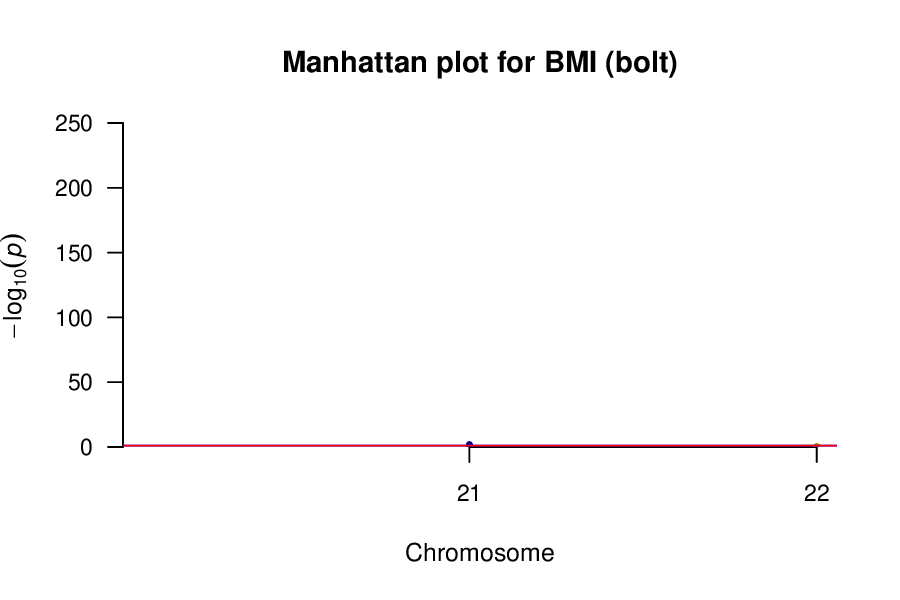

In [24]:
%preview output/phenotypes_BMI.boltlmm.manhattan.pdf -s png --dpi 150

> /home/gw/tmp/10-Jun-2020/MWE_test/output/phenotypes_BMI.boltlmm.qq.pdf (5.8 KiB):

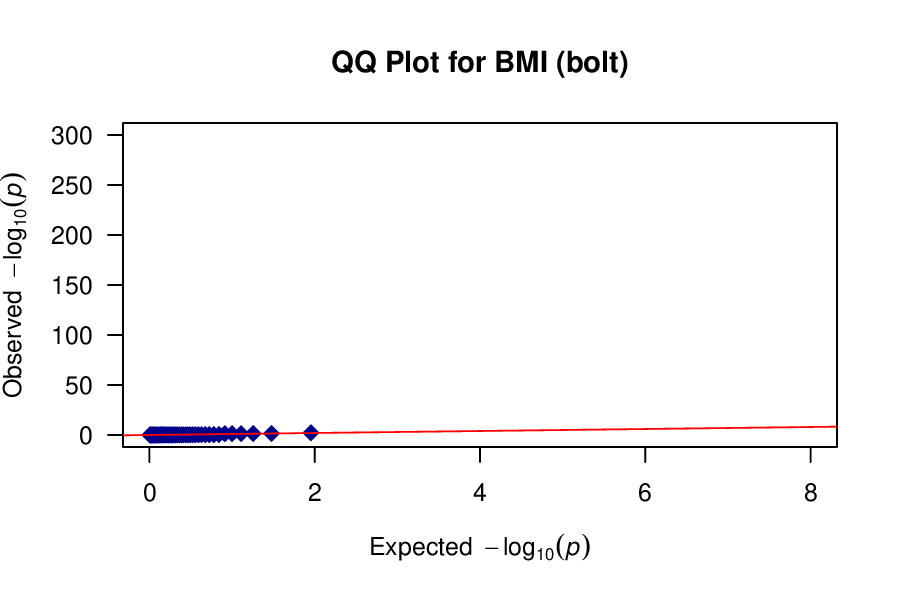

In [25]:
%preview output/phenotypes_BMI.boltlmm.qq.pdf -s png --dpi 150

> /home/gw/tmp/10-Jun-2020/MWE_test/output/phenotypes_BMI.boltlmm.manhattan_annotated.pdf (6.9 KiB):

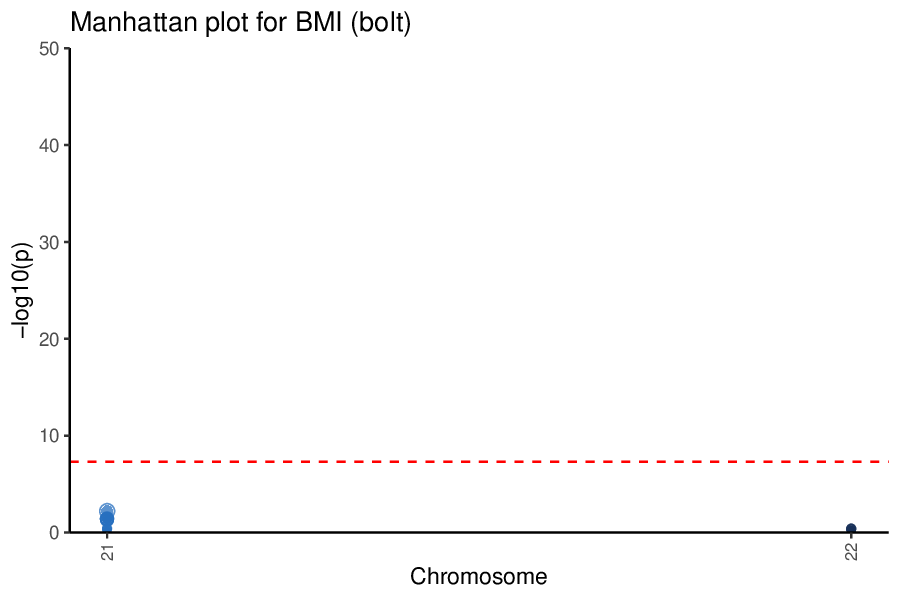

In [26]:
%preview output/phenotypes_BMI.boltlmm.manhattan_annotated.pdf -s png --dpi 150